# Testing How Best To Determine Point Removal

In [1]:
import os
import tsplib95
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import signal
import tqdm
from multiprocess import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import *
from scipy.stats import ttest_ind
from statistics import mean
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neighbors import KernelDensity

from wsp import tsp, ds

INCLUDE_LEAVES = False
# FILE_DIR, N = "DATA_GEN_20p0.25", 20
# FILE_DIR, N = "DATA_GEN_30p0.33", 30
FILE_DIR, N = "DATA_GEN_50u", 50
AX = np.array([None, None])
S_FACTOR = 2.0
S_FACTOR_B = 8.0
TREE_TYPE = ds.PKPRQuadTree

In [2]:
top_problems = sorted(os.listdir(FILE_DIR))


len(top_problems)

1000

## Problem Injestion

In [158]:
def filter_leaves(decomp):
    return all(not tree.leaf for tree in decomp) if not INCLUDE_LEAVES else True

def count_wspd(wspd):
    return sum(1 for x in wspd if filter_leaves(x[0]))

def mean_sep(pair_sep_dict):
    return mean(special_dist.sep for pair, special_dist in pair_sep_dict.items() if filter_leaves(pair))

def sum_sep(pair_sep_dict):
    return sum(special_dist.sep for pair, special_dist in pair_sep_dict.items() if filter_leaves(pair))

def rel_diff(a,b):
    return float('nan') if a == 0 and b == 0 else (a - b) / (a + b)

In [159]:
base_df = pd.DataFrame(columns=['name', 'parent', 'path_reduction', 'path_discount', 'optimal_percent', 'wsp_reduction', 'wsp_reduction_B', 'wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B', 'point_specific_wsp', 'point_specific_wsp_B', 'point_specific_wsp_weighted', 'point_specific_wsp_weighted_B', 'point_specific_sep_share', 'point_specific_sep_share_B', 'point_average_cost', 'point_maximum_cost', 'point_minimum_cost', 'point_average_cost_weighted', 'point_maximum_cost_weighted', 'point_minimum_cost_weighted'])
base_df = base_df.astype({'name': str, 'parent': str, 'path_reduction': float, 'path_discount': float, 'optimal_percent': float, 'wsp_reduction': float, 'wsp_reduction_B': float, 'wsp_spec_reduction': float, 'wsp_spec_reduction_B': float, 'wsp_spec_reduction_sep_B': float, 'wsp_spec_reduction_sep': float, 'point_specific_wsp': float, 'point_specific_wsp_B': float, 'point_specific_wsp_weighted': float, 'point_specific_wsp_weighted_B': float, 'point_specific_sep_share': float, 'point_specific_sep_share_B': float, 'point_average_cost': float, 'point_maximum_cost': float, 'point_minimum_cost': float, 'point_average_cost_weighted': float, 'point_maximum_cost_weighted': float, 'point_minimum_cost_weighted': float})
base_df.set_index('name', inplace=True)

In [160]:
removed_problems : list[tsplib95.models.StandardProblem] = []
def setup(top_problem):
    main_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{top_problem}.tsp")
    main_conc_cost = float(main_problem.comment.split(' ')[2])
    main_points = [ds.Point(*main_problem.node_coords[i]) for i in main_problem.get_nodes()]
    
    main_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR)
    main_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR_B)
    
    main_cost = main_problem_object.calc_dist(
        [main_points[i-1] for i in main_problem.tours[0]] + [main_points[main_problem.tours[0][0] - 1]]
    )

    updates = base_df.copy()
    
    best_discount = float('inf')
    
    total_sep = sum_sep(main_problem_object.pair_sep_dict)
    total_sep_B = sum_sep(main_problem_object_B.pair_sep_dict)
    main_count_wspd = count_wspd(main_problem_object.wspd)
    main_count_wspd_B = count_wspd(main_problem_object_B.wspd)
    main_mean_sep = mean_sep(main_problem_object.pair_sep_dict)
    main_mean_sep_B = mean_sep(main_problem_object_B.pair_sep_dict)
    for removal_name in os.listdir(f"{FILE_DIR}/{top_problem}"): # need to filter in only single point removals here
        if '_' not in removal_name: continue
        point_number = int(removal_name.split('_')[-1].split('.')[0]) # number of the missing point in the og

        sub_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{removal_name}")
        sub_conc_cost = float(sub_problem.comment.split(' ')[2])
        sub_points = [ds.Point(*sub_problem.node_coords[i]) for i in sub_problem.get_nodes()]
        sub_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR)
        sub_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR_B)
        sub_cost = sub_problem_object.calc_dist(
            [sub_points[i-1] for i in sub_problem.tours[0]] + [sub_points[sub_problem.tours[0][0] - 1]]
        )

        point_specific_wsp = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and main_points[point_number - 1] in tree
        )
        point_specific_wsp_B = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object_B.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and main_points[point_number - 1] in tree
        )
        
        point_specific_wsp_sep_share = sum(
            special.sep for pair, special in main_problem_object.pair_sep_dict.items()
            if any(main_points[point_number - 1] in tree for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        ) / total_sep
        
        point_specific_wsp_sep_share_B = sum(
            special.sep for pair, special in main_problem_object_B.pair_sep_dict.items()
            if any(main_points[point_number - 1] in tree for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        ) / total_sep_B
        
        point_edge_costs = main_problem_object.dist_matrix_with_nan[point_number - 1]
        
        best_discount = min(best_discount, (sub_conc_cost / main_conc_cost))

        updates.loc[sub_problem.name] = {
            'parent': top_problem,
            'path_reduction': sub_conc_cost / main_conc_cost,
            'path_discount': 1.0 - (sub_conc_cost / main_conc_cost),
            'wsp_spec_reduction': rel_diff(main_count_wspd, count_wspd(sub_problem_object.wspd)),
            'wsp_spec_reduction_B': rel_diff(main_count_wspd_B, count_wspd(sub_problem_object_B.wspd)),
            'wsp_spec_reduction_sep': rel_diff(main_mean_sep, mean_sep(sub_problem_object.pair_sep_dict)),
            'wsp_spec_reduction_sep_B': rel_diff(main_mean_sep_B, mean_sep(sub_problem_object_B.pair_sep_dict)),
            'point_specific_wsp': point_specific_wsp,
            'point_specific_wsp_B': point_specific_wsp_B,
            'point_specific_wsp_weighted': point_specific_wsp / main_count_wspd,
            'point_specific_wsp_weighted_B': point_specific_wsp_B / main_count_wspd_B,
            'point_specific_sep_share': point_specific_wsp_sep_share,
            'point_specific_sep_share_B': point_specific_wsp_sep_share_B,
            'point_average_cost': np.nanmean(point_edge_costs),
            'point_maximum_cost': np.nanmax(point_edge_costs),
            'point_minimum_cost': np.nanmin(point_edge_costs),
            'point_average_cost_weighted': np.nanmean(point_edge_costs) / main_cost,
            'point_maximum_cost_weighted': np.nanmax(point_edge_costs) / main_cost,
            'point_minimum_cost_weighted': np.nanmin(point_edge_costs) / main_cost,
        }
    updates['optimal_percent'] = updates['path_discount'] / best_discount
    return updates

original_sigint_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)
pool = Pool(7) # NUMBER OF PROCESSES
signal.signal(signal.SIGINT, original_sigint_handler)

update_collection = []
u=0
try:
    with tqdm.tqdm(total=len(top_problems), unit="top problem") as pbar:
        for result in pool.imap_unordered(setup, top_problems):
            update_collection.append(result)
            pbar.update(1)
            prob_name = next(iter(result))
            u += 1
            # if result[prob_name] != {}:
            #     u += 1
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name, "last_updated": prob_name, "updated": u}})
            # else:
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name}})
except KeyboardInterrupt:
    print("Caught KeyboardInterrupt, terminating workers")
    pool.terminate()
else:
    pool.close()
pool.join()

print("Injesting updates")
reduction_df = pd.concat(update_collection)
reduction_df

100%|██████████| 1000/1000 [02:05<00:00,  7.99top problem/s]


Injesting updates


,parent,path_reduction,path_discount,optimal_percent,wsp_reduction,wsp_reduction_B,wsp_spec_reduction,wsp_spec_reduction_B,wsp_spec_reduction_sep,wsp_spec_reduction_sep_B,...,point_specific_wsp_weighted,point_specific_wsp_weighted_B,point_specific_sep_share,point_specific_sep_share_B,point_average_cost,point_maximum_cost,point_minimum_cost,point_average_cost_weighted,point_maximum_cost_weighted,point_minimum_cost_weighted
name,,,,,,,,,,,,,,,,,,,,,
aae50u_4,aae50u,0.994534,0.005466,0.005695,NaN,NaN,0.009009,0.074627,0.010060,-0.014240,...,0.125000,0.138889,0.121717,0.114009,4408.751861,9202.274338,644.018633,0.073694,0.153819,0.010765
aae50u_49,aae50u,0.980377,0.019623,0.020448,NaN,NaN,-0.026087,-0.040000,-0.019069,0.011734,...,0.089286,0.000000,0.068702,0.000000,4567.503823,8630.865600,1382.236593,0.076347,0.144268,0.023105
aae50u_48,aae50u,0.998880,0.001120,0.001167,NaN,NaN,0.056604,0.066667,-0.007307,0.029423,...,0.116071,0.125000,0.098577,0.175019,4698.122676,8363.977642,179.613474,0.078531,0.139807,0.003002
aae50u_5,aae50u,0.997242,0.002758,0.002874,NaN,NaN,0.009009,0.021277,-0.003843,-0.000375,...,0.133929,0.138889,0.125227,0.123616,5838.472280,10639.063305,450.809272,0.097592,0.177836,0.007535
aae50u_7,aae50u,0.980126,0.019874,0.020709,NaN,NaN,-0.008850,-0.020408,-0.004118,-0.004879,...,0.116071,0.083333,0.103659,0.057787,5505.338888,9401.768610,1161.607937,0.092024,0.157154,0.019417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bml50u_8,bml50u,0.994627,0.005373,0.005585,NaN,NaN,0.000000,0.000000,-0.010083,0.000000,...,0.134146,0.000000,0.140628,0.000000,6211.741015,9792.106617,1654.786995,0.116297,0.183329,0.030981
bml50u_22,bml50u,0.982831,0.017169,0.017844,NaN,NaN,-0.006061,0.000000,-0.003764,0.000000,...,0.097561,0.000000,0.078866,0.000000,5463.519733,10977.349862,801.355102,0.102289,0.205520,0.015003
bml50u_36,bml50u,0.994027,0.005973,0.006207,NaN,NaN,0.025000,-0.056911,-0.066719,0.007336,...,0.158537,0.137931,0.152002,0.122485,5738.957590,10631.827736,721.208014,0.107446,0.199051,0.013503


In [165]:
ge0_reduc_df = reduction_df[reduction_df['point_specific_wsp'] > 0]
reduction_df['wsp_spec_reduction'].describe(), reduction_df['wsp_spec_reduction'].isna().sum()
# reduction_df = reduction_df[reduction_df['wsp_spec_reduction'].notna()]

(count    50000.000000
 mean         0.017026
 std          0.030522
 min         -0.238095
 25%          0.000000
 50%          0.005988
 75%          0.031056
 max          0.251613
 Name: wsp_spec_reduction, dtype: float64,
 np.int64(0))

## WSP Reduction Calculations
How much does the difference in global well seperated pairs actually predict anything

In [7]:
reduction_df = reduction_df[reduction_df['wsp_spec_reduction_B'].notna()]
reduction_df = reduction_df[reduction_df['wsp_spec_reduction'].notna()]

In [166]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["wsp_spec_reduction"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["wsp_spec_reduction", "wsp_spec_reduction_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 1.373e-06
Date:                Sat, 14 Jun 2025   Prob (F-statistic):              0.999
Time:                        00:27:45   Log-Likelihood:             1.5991e+05
No. Observations:               50000   AIC:                        -3.198e+05
Df Residuals:                   49998   BIC:                        -3.198e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9912   5.06

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1482.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        00:27:46   Log-Likelihood:             1.6134e+05
No. Observations:               50000   AIC:                        -3.227e+05
Df Residuals:                   49997   BIC:                        -3.227e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9905   5.05e-05   1.96e+04      0.000       0.990       0.991
wsp_spec_reduction      -0.0487      0.002    -29.210      0.000      -0.052      -0.045
wsp_spec_reduction_B     0.0529      0.001     54.437      0.000       0.051       0.055
==============================================================================
Omnibus:                    21886.944   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           128141.540
Skew:                          -2.046   Prob(JB):                         0.00
Kurtosis:                       9.691   Cond. No.                         41.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [167]:
results2 = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2) + wsp_spec_reduction_B + I(wsp_spec_reduction_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     862.3
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        00:27:51   Log-Likelihood:             1.6075e+05
No. Observations:               50000   AIC:                        -3.215e+05
Df Residuals:                   49997   BIC:                        -3.215e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1138.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        00:27:51   Log-Likelihood:             1.6208e+05
No. Observations:               50000   AIC:                        -3.242e+05
Df Residuals:                   49995   BIC:                        -3.241e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9909   5.09e-05   1.95e+04      0.000       0.991       0.991
wsp_spec_reduction              -0.0139      0.002     -5.912      0.000      -0.019      -0.009
I(wsp_spec_reduction ** 2)      -0.5675      0.026    -22.118      0.000      -0.618      -0.517
wsp_spec_reduction_B             0.0591      0.001     51.239      0.000       0.057       0.061
I(wsp_spec_reduction_B ** 2)    -0.1328      0.007    -18.875      0.000      -0.147      -0.119
==============================================================================
Omnibus:                    21163.408   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           123216.278
Skew:                          -1.966   Prob(JB):                         0.00
Kurtosis:                       9.609   Cond. No.                         613.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/1037681458.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/1037681458.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


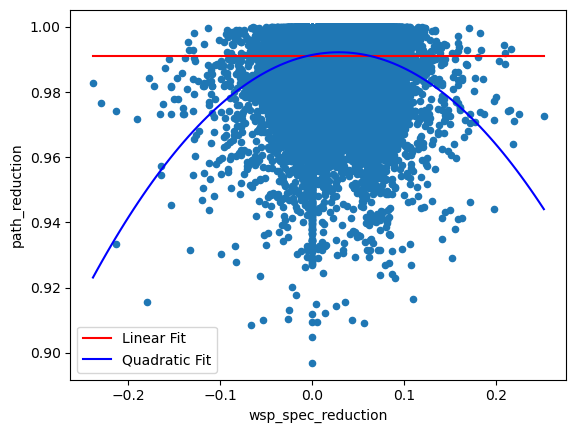

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/1037681458.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9911664158060508)

In [168]:
reduction_df.plot.scatter("wsp_spec_reduction", "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df["wsp_spec_reduction"].min(), reduction_df["wsp_spec_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [169]:
reduction_df["wsp_spec_reduction"].values

array([ 0.00900901, -0.02608696,  0.05660377, ...,  0.025     ,
        0.        ,  0.        ], shape=(50000,))

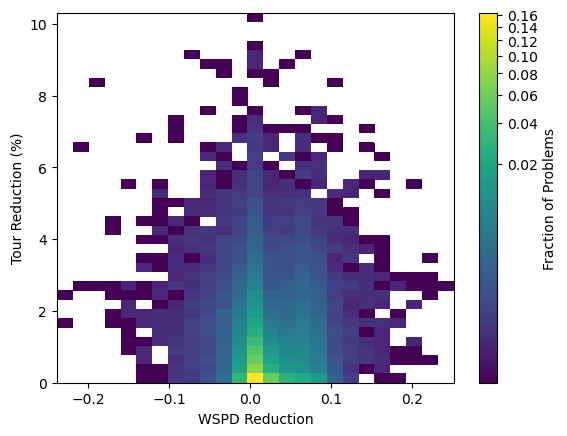

In [170]:
# dummy plot for no output

plt.style.use('default')  # Use the default (light) matplotlib style

h = plt.hist2d(
    reduction_df["wsp_spec_reduction"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.25),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["wsp_spec_reduction"])
norm = PowerNorm(0.25)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('WSPD Reduction')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

### Discount class predictions

In [207]:
COMPARISON_SIZE = 5
path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(COMPARISON_SIZE, 'path_reduction'))
path_largest = reduction_df.groupby("parent").apply(lambda df: df.nlargest(N-COMPARISON_SIZE, 'path_reduction'))

clf_df = pd.concat([
    path_smallest.assign(target=1),
    path_largest.assign(target=0)
])

# Create y to match clf_df
y = clf_df['target']

# Ensure problems with the same parent are either all in train or all in test
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
groups = clf_df['parent']
train_idx, test_idx = next(gss.split(clf_df, y, groups=groups))

X_train, X_test = clf_df.iloc[train_idx].reset_index(drop=True, level='parent'), clf_df.iloc[test_idx].reset_index(drop=True, level='parent')
y_train, y_test = y.iloc[train_idx].reset_index(drop=True, level='parent'), y.iloc[test_idx].reset_index(drop=True, level='parent')

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/1218025974.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(COMPARISON_SIZE, 'path_reduction'))
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/1218025974.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_largest = reduction_df.groupby("pare

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/1986339396.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/1986339396.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     29.49
Date:                Sat, 14 Jun 2025   Prob (F-statistic):           1.86e-13
Time:                        01:09:15   Log-Likelihood:                 15542.
No. Observations:                5000   AIC:                        -3.108e+04
Df Residuals:                    4997   BIC:                        -3.106e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.9695      0.000   5576.139      0.000       0.969       0.970
wsp_spec_reduction             0.0170      0.004      3.997      0.000       0.009       0.025
I(wsp_spec_reduction ** 2)    -0.3264      0.043     -7.679      0.000      -0.410      -0.243
==============================================================================
Omnibus:                     1661.372   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5916.613
Skew:                          -1.653   Prob(JB):                         0.00
Kurtosis:                       7.180   Cond. No.                         278.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

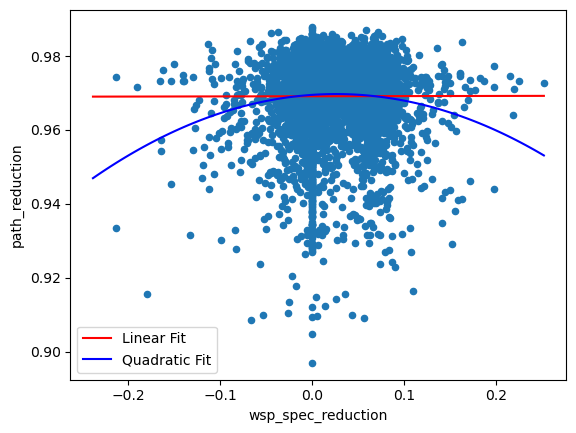

In [208]:
path_smallest.plot.scatter("wsp_spec_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"], sm.add_constant(path_smallest["wsp_spec_reduction"])).fit()

x = np.linspace(reduction_df["wsp_spec_reduction"].min(), reduction_df["wsp_spec_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

results2 = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2)", data=path_smallest).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')
plt.legend()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.64
Date:                Sat, 14 Jun 2025   Prob (F-statistic):           0.000130
Time:                        01:09:16   Log-Likelihood:             1.6682e+05
No. Observations:               45000   AIC:                        -3.336e+05
Df Residuals:                   44998   BIC:                        -3.336e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9936   3.24e-05   3.07e+04      0.000       0.993       0.994
wsp_spec_reduction     0.0037      0.001      3.826      0.000       0.002       0.006
==============================================================================
Omnibus:                     5367.989   Durbin-Watson:                   0.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7513.535
Skew:                          -0.991   Prob(JB):                         0.00
Kurtosis:                       3.284   Cond. No.                         34.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

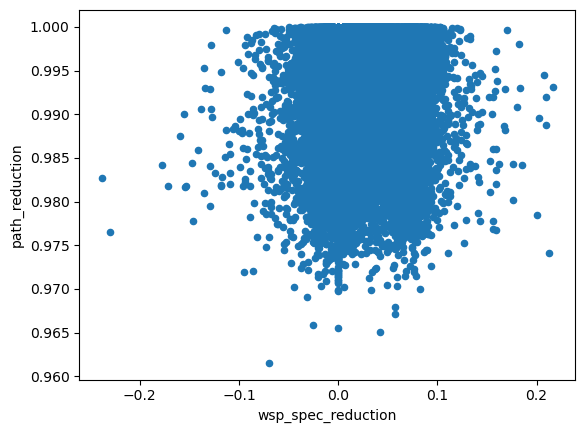

In [209]:
path_largest.plot.scatter("wsp_spec_reduction", "path_reduction")
results = sm.OLS(path_largest["path_reduction"], sm.add_constant(path_largest["wsp_spec_reduction"])).fit()
results.summary()

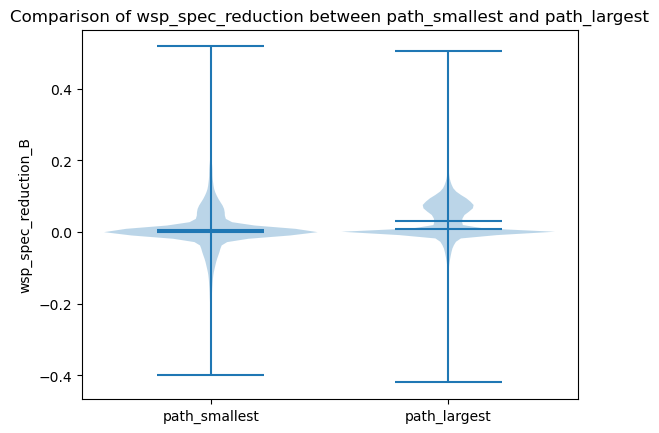

T-statistic: -24.3299, p-value: 1.718e-124
The means are statistically significantly different (p < 0.05).


In [210]:
# Create a DataFrame for violin plot comparison
violin_data = [
    path_smallest['wsp_spec_reduction_B'],
    path_largest['wsp_spec_reduction_B']
]

plt.violinplot(violin_data, showmedians=True, showmeans=True, showextrema=True, points=100, widths=0.9)
plt.xticks([1, 2], ['path_smallest', 'path_largest'])
plt.ylabel('wsp_spec_reduction_B')
plt.title('Comparison of wsp_spec_reduction between path_smallest and path_largest')
plt.show()

# Perform independent t-test
stat, p_value = ttest_ind(
    path_smallest['wsp_spec_reduction_B'],
    path_largest['wsp_spec_reduction_B'],
    nan_policy='omit',
    equal_var=False  # Use Welch's t-test if variances are unequal
)

print(f"T-statistic: {stat:.4f}, p-value: {p_value:.4g}")
if p_value < 0.05:
    print("The means are statistically significantly different (p < 0.05).")
else:
    print("No statistically significant difference between means (p >= 0.05).")

In [211]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B']].values, X_test[['wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[ 12.10820666 -11.1941502   -5.78314734   1.97164659]] [-0.0222681]
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      6750
           1       0.15      0.56      0.23       750

    accuracy                           0.62      7500
   macro avg       0.54      0.60      0.49      7500
weighted avg       0.85      0.62      0.70      7500

ROC AUC: 0.663427950617284


We are able to do a fair job of predicting whether the number of wsps the problem is reduced by has a predictive effect on the shortness of the problem. 

In [212]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth=0.005)
kde_0 = KernelDensity(kernel='exponential', bandwidth=0.005)

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.95      0.51      0.67      6750
           1       0.15      0.78      0.25       750

    accuracy                           0.54      7500
   macro avg       0.55      0.64      0.46      7500
weighted avg       0.87      0.54      0.63      7500

ROC AUC: 0.7107841975308642


## How much does the wsps on a specific point actually matter

In [213]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["point_specific_wsp", "point_specific_wsp_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     6079.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:09:28   Log-Likelihood:             1.6277e+05
No. Observations:               50000   AIC:                        -3.255e+05
Df Residuals:                   49998   BIC:                        -3.255e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9814      0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     4423.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:09:28   Log-Likelihood:             1.6398e+05
No. Observations:               50000   AIC:                        -3.279e+05
Df Residuals:                   49997   BIC:                        -3.279e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9834      0.000   7242.644      0.000       0.983       0.984
point_specific_wsp       0.0005   1.55e-05     30.384      0.000       0.000       0.001
point_specific_wsp_B     0.0006   1.25e-05     49.671      0.000       0.001       0.001
==============================================================================
Omnibus:                    19176.622   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            98318.867
Skew:                          -1.797   Prob(JB):                         0.00
Kurtosis:                       8.854   Cond. No.                         40.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [214]:
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2) + point_specific_wsp_B + I(point_specific_wsp_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     3064.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:09:28   Log-Likelihood:             1.6280e+05
No. Observations:               50000   AIC:                        -3.256e+05
Df Residuals:                   49997   BIC:                        -3.256e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     2366.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:09:28   Log-Likelihood:             1.6424e+05
No. Observations:               50000   AIC:                        -3.285e+05
Df Residuals:                   49995   BIC:                        -3.284e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9813      0.000   5414.247      0.000       0.981       0.982
point_specific_wsp               0.0012   4.23e-05     27.856      0.000       0.001       0.001
I(point_specific_wsp ** 2)    -5.06e-05   2.55e-06    -19.866      0.000   -5.56e-05   -4.56e-05
point_specific_wsp_B             0.0011   3.81e-05     29.168      0.000       0.001       0.001
I(point_specific_wsp_B ** 2) -3.829e-05   3.17e-06    -12.060      0.000   -4.45e-05   -3.21e-05
==============================================================================
Omnibus:                    18629.607   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91873.473
Skew:                          -1.753   Prob(JB):                         0.00
Kurtosis:                       8.640   Cond. No.                         634.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/830609850.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/830609850.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


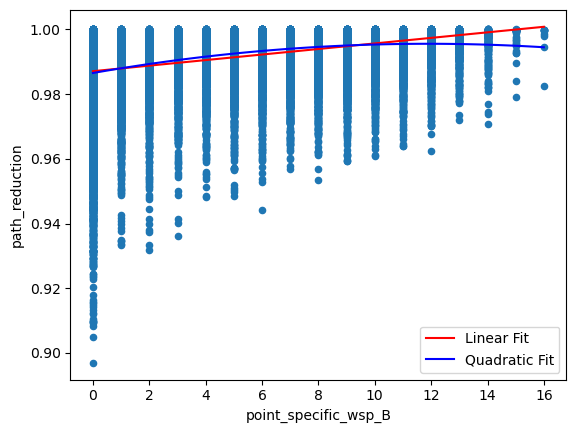

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/830609850.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9870999762149806)

In [215]:
reduction_df.plot.scatter("point_specific_wsp_B", "path_reduction")
# Plot the first fitted model
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp_B"])).fit()
x = np.linspace(reduction_df["point_specific_wsp_B"].min(), reduction_df["point_specific_wsp_B"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp_B + I(point_specific_wsp_B**2)", data=reduction_df).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

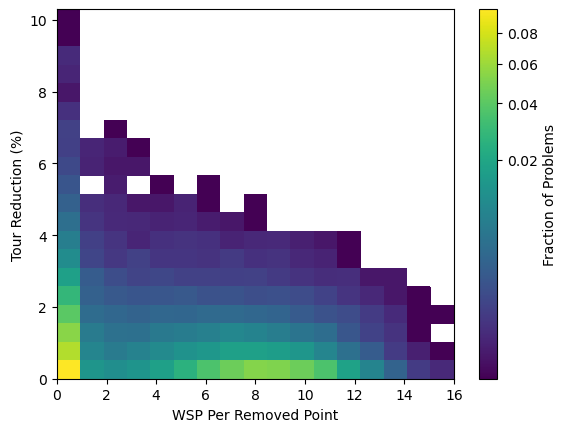

In [216]:
# dummy plot for no output

plt.style.use('default')  # Use the default (light) matplotlib style

h = plt.hist2d(
    reduction_df["point_specific_wsp_B"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(17,20),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_specific_wsp_B"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('WSP Per Removed Point')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [217]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_specific_wsp', 'point_specific_wsp_B']].values, X_test[['point_specific_wsp', 'point_specific_wsp_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[-0.07314956 -0.1937843 ]] [1.29582283]
              precision    recall  f1-score   support

           0       0.96      0.62      0.76      6750
           1       0.19      0.77      0.30       750

    accuracy                           0.64      7500
   macro avg       0.57      0.70      0.53      7500
weighted avg       0.88      0.64      0.71      7500

ROC AUC: 0.7395307654320988


In [218]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth=0.005)
kde_0 = KernelDensity(kernel='exponential', bandwidth=0.005)

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.96      0.61      0.75      6750
           1       0.18      0.79      0.30       750

    accuracy                           0.63      7500
   macro avg       0.57      0.70      0.52      7500
weighted avg       0.88      0.63      0.70      7500

ROC AUC: 0.7354554074074073


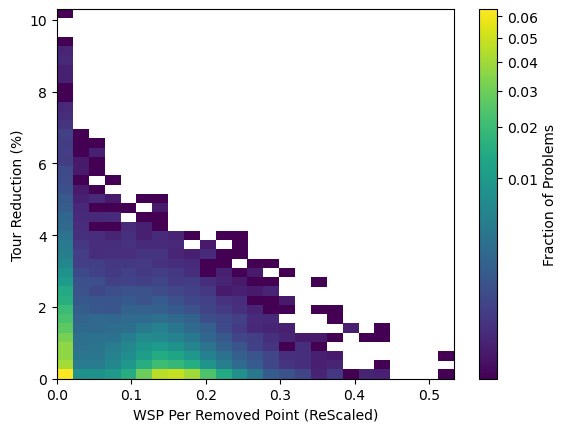

In [219]:
plt.style.use('default')  # Use the default (light) matplotlib style

h = plt.hist2d(
    reduction_df["point_specific_wsp_weighted_B"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_specific_wsp_weighted_B"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('WSP Per Removed Point (ReScaled)')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [220]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_specific_wsp_weighted', 'point_specific_wsp_weighted_B']].values, X_test[['point_specific_wsp_weighted', 'point_specific_wsp_weighted_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[ -6.6073734  -10.62369546]] [1.39508694]
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      6750
           1       0.19      0.77      0.31       750

    accuracy                           0.65      7500
   macro avg       0.58      0.70      0.54      7500
weighted avg       0.88      0.65      0.72      7500

ROC AUC: 0.7489713580246914


In [221]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth='silverman')
kde_0 = KernelDensity(kernel='exponential', bandwidth='silverman')

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      6750
           1       0.00      0.00      0.00       750

    accuracy                           0.90      7500
   macro avg       0.45      0.50      0.47      7500
weighted avg       0.81      0.90      0.85      7500

ROC AUC: 0.7489172345679013


/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

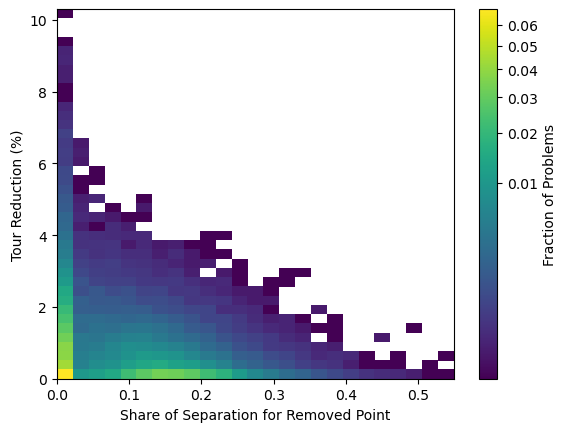

In [222]:
h = plt.hist2d(
    reduction_df["point_specific_sep_share_B"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_specific_sep_share_B"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('Share of Separation for Removed Point')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [223]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_specific_sep_share', 'point_specific_sep_share_B']].values, X_test[['point_specific_sep_share', 'point_specific_sep_share_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[ -2.93242628 -12.7384907 ]] [1.00382055]
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      6750
           1       0.18      0.80      0.29       750

    accuracy                           0.62      7500
   macro avg       0.57      0.70      0.52      7500
weighted avg       0.89      0.62      0.69      7500

ROC AUC: 0.7509651358024692


In [224]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth='scott')
kde_0 = KernelDensity(kernel='exponential', bandwidth='scott')

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      6750
           1       0.00      0.00      0.00       750

    accuracy                           0.90      7500
   macro avg       0.45      0.50      0.47      7500
weighted avg       0.81      0.90      0.85      7500

ROC AUC: 0.748979950617284


/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

### Considering all metrics

In [225]:
# Subscript the training data
metrics = ['point_specific_wsp_weighted', 'point_specific_wsp_weighted_B', 'point_specific_wsp', 'point_specific_wsp_B', 'point_specific_sep_share', 'point_specific_sep_share_B',
           'wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B']
X_train_reduc, X_test_reduc = X_train[metrics].values, X_test[metrics].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[-1.33808029e+01  7.36318300e+00 -6.66117350e-02 -9.29966922e-03
   8.09749296e+00 -1.80524952e+01  1.22877984e+01 -1.41874890e+00
  -1.21682336e+01  2.35940318e+00]] [1.61740635]
              precision    recall  f1-score   support

           0       0.97      0.61      0.75      6750
           1       0.19      0.81      0.31       750

    accuracy                           0.63      7500
   macro avg       0.58      0.71      0.53      7500
weighted avg       0.89      0.63      0.71      7500

ROC AUC: 0.7788272592592593


/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [226]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth=0.02)
kde_0 = KernelDensity(kernel='exponential', bandwidth=0.02)

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      6750
           1       0.19      0.81      0.31       750

    accuracy                           0.64      7500
   macro avg       0.58      0.71      0.53      7500
weighted avg       0.89      0.64      0.71      7500

ROC AUC: 0.7853475555555556


/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/609549793.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)


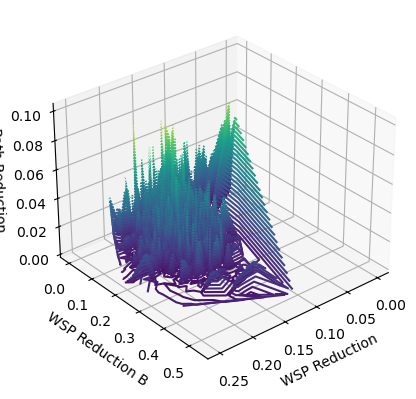

In [227]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
x = np.linspace(reduction_df["point_specific_wsp_weighted"].min(), reduction_df["point_specific_wsp_weighted"].max(), 100)
y = np.linspace(reduction_df["point_specific_wsp_weighted_B"].min(), reduction_df["point_specific_wsp_weighted_B"].max(), 100)
X, Y = np.meshgrid(x, y)
Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)
# ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
# Plot the scatter points
# ax.scatter(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], color='r', alpha=0.1)
ax.tricontour(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], 40, cmap='viridis')
ax.set_xlabel('WSP Reduction')
ax.set_ylabel('WSP Reduction B')
ax.set_zlabel('Path Reduction')

ax.view_init(azim=50, elev=30)

plt.show()

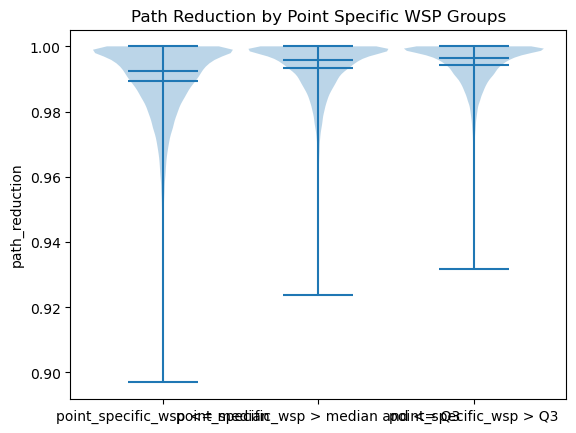

In [228]:
median = reduction_df['point_specific_wsp'].median()
q1 = reduction_df['point_specific_wsp'].quantile(0.25)
q3 = reduction_df['point_specific_wsp'].quantile(0.75)

data = [
    reduction_df[reduction_df['point_specific_wsp'] <= median]['path_reduction'],
    reduction_df[(reduction_df['point_specific_wsp'] > median) & (reduction_df['point_specific_wsp'] <= q3)]['path_reduction'],
    reduction_df[reduction_df['point_specific_wsp'] > q3]['path_reduction']
]

plt.violinplot(data, widths=0.9, points=100, showmeans=True, showmedians=True, showextrema=True)
plt.xticks([1, 2, 3], ['point_specific_wsp <= median', 'point_specific_wsp > median and <= Q3', 'point_specific_wsp > Q3'])
plt.ylabel('path_reduction')
plt.title('Path Reduction by Point Specific WSP Groups')
plt.show()

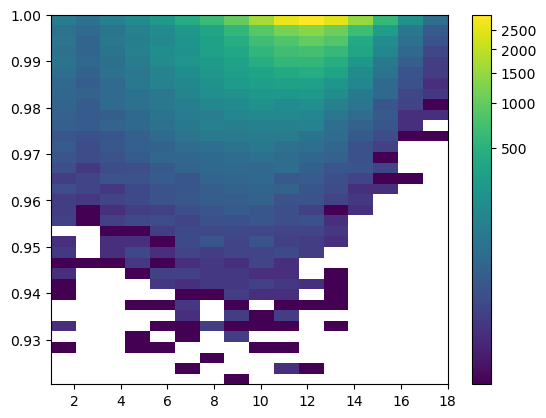

In [229]:
h = plt.hist2d(ge0_reduc_df["point_specific_wsp"], ge0_reduc_df["path_reduction"], bins=(16,35), cmin=1, norm=PowerNorm(0.25))
plt.colorbar(h[3])

## How well do other geometric tools work for this

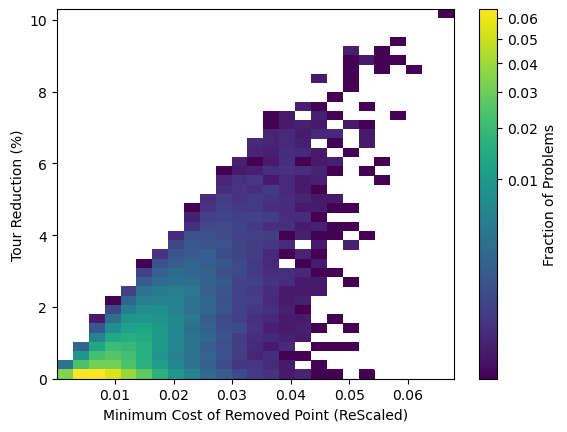

In [230]:
h = plt.hist2d(
    reduction_df["point_minimum_cost_weighted"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_minimum_cost_weighted"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('Minimum Cost of Removed Point (ReScaled)')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [231]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_minimum_cost_weighted']].values, X_test[['point_minimum_cost_weighted']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[285.42403386]] [-5.04551404]
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      6750
           1       0.34      0.83      0.49       750

    accuracy                           0.82      7500
   macro avg       0.66      0.83      0.69      7500
weighted avg       0.91      0.82      0.85      7500

ROC AUC: 0.9111614814814815


In [232]:
variable = "point_specific_wsp_weighted"

results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[variable])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     6595.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:10:05   Log-Likelihood:             1.6300e+05
No. Observations:               50000   AIC:                        -3.260e+05
Df Residuals:                   49998   BIC:                        -3.260e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.9808      0.000   7319.524      0.000       0.981       0.981
point_specific_wsp_weighted     0.0822      0.001     81.209      0.000       0.080       0.084
==============================================================================
Omnibus:                    19162.626   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92464.372
Skew:                          -1.820   Prob(JB):                         0.00
Kurtosis:                       8.579   Cond. No.                         24.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [233]:
results2 = smf.ols(formula=f"path_reduction ~ {variable} + I({variable}**2)", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     3307.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:10:05   Log-Likelihood:             1.6301e+05
No. Observations:               50000   AIC:                        -3.260e+05
Df Residuals:                   49997   BIC:                        -3.260e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.9803      0.000   5281.896      0.000       0.980       0.981
point_specific_wsp_weighted             0.0960      0.003     27.773      0.000       0.089       0.103
I(point_specific_wsp_weighted ** 2)    -0.0688      0.016     -4.189      0.000      -0.101      -0.037
==============================================================================
Omnibus:                    19093.228   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91637.231
Skew:                          -1.815   Prob(JB):                         0.00
Kurtosis:                       8.551   Cond. No.                         406.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/1114625799.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/1114625799.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


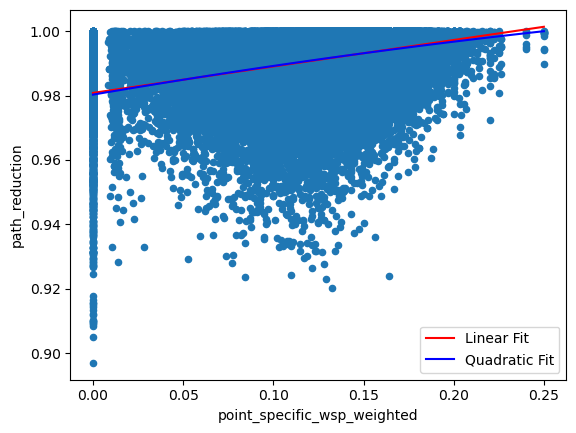

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47578/1114625799.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9808204485674151)

In [234]:
reduction_df.plot.scatter(variable, "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df[variable].min(), reduction_df[variable].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [235]:
results2 = smf.ols(formula=f"optimal_percent ~ point_specific_wsp_weighted + I(point_specific_wsp_weighted**2) + point_average_cost_weighted + I(point_average_cost_weighted**2) + point_maximum_cost_weighted + point_maximum_cost_weighted + I(point_maximum_cost_weighted**2) + point_minimum_cost_weighted", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        optimal_percent   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     6528.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:10:05   Log-Likelihood:             1.7359e+05
No. Observations:               50000   AIC:                        -3.472e+05
Df Residuals:                   49992   BIC:                        -3.471e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0417      0.001     35.313      0.000       0.039       0.044
point_specific_wsp_weighted            -0.0428      0.003    -15.187      0.000      -0.048      -0.037
I(point_specific_wsp_weighted ** 2)     0.1440      0.013     10.826      0.000       0.118       0.170
point_average_cost_weighted            -1.0089      0.031    -32.122      0.000      -1.071      -0.947
I(point_average_cost_weighted ** 2)     5.2645      0.161     32.687      0.000       4.949       5.580
point_maximum_cost_weighted             0.0395      0.020      1.982      0.047       0.000       0.079
I(point_maximum_cost_weighted ** 2)    -0.0408      0.059     -0.698      0.485      -0.155       0.074
point_minimum_cost_weighted             0.8928      0.005    166.407      0.000       0.882       0.903
==============================================================================
Omnibus:                     3890.190   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12412.093
Skew:                           0.390   Prob(JB):                         0.00
Kurtosis:                       5.313   Cond. No.                     5.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [236]:
pca = sm.PCA(reduction_df[["point_specific_wsp_weighted", "point_average_cost_weighted", "point_maximum_cost_weighted", "point_minimum_cost_weighted"]][:5000].T)

pca.factors

,comp_0,comp_1,comp_2,comp_3
point_specific_wsp_weighted,-0.242945,0.831179,-0.010945,0.807444
point_average_cost_weighted,0.077363,-0.267366,0.820079,0.302089
point_maximum_cost_weighted,-0.595915,-0.480294,-0.405220,1.042780
point_minimum_cost_weighted,0.761497,-0.083519,-0.403914,-1.787933


<Axes: xlabel='point_specific_wsp_weighted', ylabel='point_maximum_cost_weighted'>

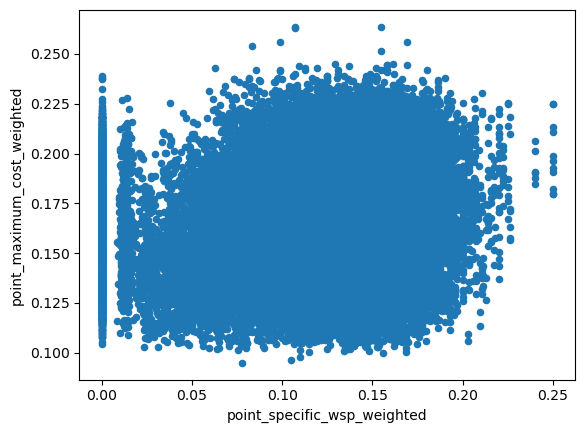

In [237]:
reduction_df.plot.scatter("point_specific_wsp_weighted", "point_maximum_cost_weighted")